Numpy array ...
[ 0.          0.19866933  0.38941834 ...,  0.0211657   0.21936862
  0.40882601]
Plot of first 100 points ...


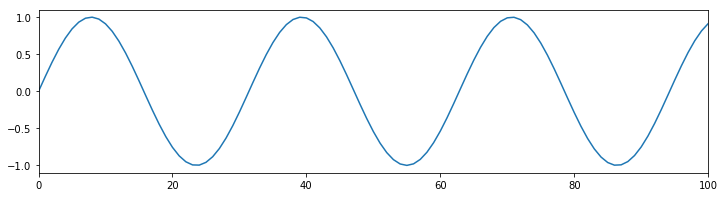

Pandas DataFrame format ...
      sinwave
idx          
0    0.000000
1    0.198669
2    0.389418
3    0.564642
4    0.717356
Saving CSV file ...


In [107]:
from math import sin
import matplotlib.pyplot as plt
import numpy
import pandas

# sin generation parameters 
x0 = 0.0
step = 0.2
nsteps = 100000

data = []
x = x0

for i in range(0,nsteps):
    y = sin(x)
    x = x + step
    data.append(y)
    
# Convert to numpy array
data = numpy.array(data)
print('Numpy array ...')
print(data)

# Plot
print('Plot of first 100 points ...')
plt.rcParams["figure.figsize"] = [12,3]
plt.xlim(0,100)
plt.plot(data)
plt.show()

# Convert to pandas DataFrame format
data = pandas.DataFrame(data)
data.columns = ['sinwave']
data.index.name = 'idx'
print('Pandas DataFrame format ...')
print(data.head())

# save as coma separated value file
print('Saving CSV file ...')
data.to_csv('~/test-data/syntetic-data.csv')

In [108]:
filename = '~/test-data/syntetic-data.csv'

sequence_len = 8
features_len = 2
total_len = sequence_len + features_len

# Read CVS file with data
df = pandas.read_csv(filename,index_col=0)

print('DataFrame after reading CSV file ...')
print(df.head())

# Change the name of the column for numeric
df.columns = [0]

# Create columns with shifted data to create rows of connected data
for i in range(1,total_len):  
    df[i] = df[i-1].shift(-1)
    
# drop all rows with NaN elements 
df = df.dropna()

print('DataFrame after creating sets of data ...')

print(df.head())

DataFrame after reading CSV file ...
      sinwave
idx          
0    0.000000
1    0.198669
2    0.389418
3    0.564642
4    0.717356
DataFrame after creating sets of data ...
            0         1         2         3         4         5         6  \
idx                                                                         
0    0.000000  0.198669  0.389418  0.564642  0.717356  0.841471  0.932039   
1    0.198669  0.389418  0.564642  0.717356  0.841471  0.932039  0.985450   
2    0.389418  0.564642  0.717356  0.841471  0.932039  0.985450  0.999574   
3    0.564642  0.717356  0.841471  0.932039  0.985450  0.999574  0.973848   
4    0.717356  0.841471  0.932039  0.985450  0.999574  0.973848  0.909297   

            7         8         9  
idx                                
0    0.985450  0.999574  0.973848  
1    0.999574  0.973848  0.909297  
2    0.973848  0.909297  0.808496  
3    0.909297  0.808496  0.675463  
4    0.808496  0.675463  0.515501  


In [109]:
import math 

values = df.values
training_len = math.floor(len(values)*0.75)

# Assign training set (train_x) of data series as 75% of the data 
# we have read from the file, the rest will be used a validation 
# (testing) set (test_x) - data is represented by 'traning_len' 
# first columns of the generated vector
train_x = values[:training_len,:-features_len]
test_x  = values[training_len:,:-features_len]

# Assign true values (features) that we will try to predict for training
# and testing parts - this data is represented by last two columns of the 
# original array
train_y = values[:training_len,-features_len:]
test_y  = values[training_len:,-features_len:]

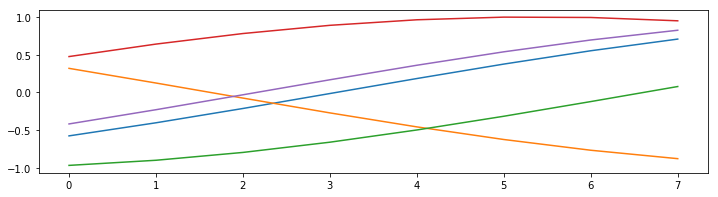

In [110]:
# Plot random sample of training sequences
n_samples = 5

plt.rcParams["figure.figsize"] = [12,3]

dat = df.sample(n_samples).values[:,:-2].T

plt.plot(dat)
plt.show()

In [111]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input, Dense, RepeatVector
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

def build_autoencoder_model(timesteps, len_per_timestep):
    
    latent_dim = 5
    
    inputs = Input(shape=(timesteps, len_per_timestep))
    
#     encoded = LSTM(100, return_sequences=True)(inputs)
#     encoded = LSTM(latent_dim)(encoded)
#     decoded = RepeatVector(timesteps)(encoded)
#     decoded = LSTM(100, return_sequences=True)(decoded)
#     decoded = LSTM(len_per_timestep, return_sequences=True)(decoded)
        
        
    encoded = LSTM(10, return_sequences=True, activation='tanh')(inputs)
    encoded = LSTM(10, return_sequences=True, activation='tanh')(encoded)
    encoded = LSTM(latent_dim, return_sequences=True)(encoded)
    decoded = LSTM(10, return_sequences=True, activation='tanh')(encoded)
    decoded = LSTM(10, return_sequences=True, activation='tanh')(decoded)
    decoded = LSTM(len_per_timestep, return_sequences=True, activation='tanh')(decoded)
        
    autoencoder = Model(inputs=inputs, outputs=decoded)
        
    return autoencoder

n_labels = 2
timesteps = 8
len_per_timestep = 1
b_size = 512 
n_epochs = 20

# reshape to (n_samples, timesteps, len_per_timestep), len_per_timestep - features per time step
train_x = train_x.reshape((train_x.shape[0], timesteps, len_per_timestep))
test_x = test_x.reshape((test_x.shape[0], timesteps, len_per_timestep))

print(train_x.shape)

autoencoder = build_autoencoder_model(timesteps, len_per_timestep)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=n_epochs,
                    batch_size=b_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,callbacks=[checkpointer, tensorboard])


(74993, 8, 1)
Train on 74993 samples, validate on 24998 samples
Epoch 1/20
74993/74993 [==============================] - 18s - loss: 0.4434 - acc: 1.0001e-05 - val_loss: 0.3396 - val_acc: 0.0000e+00
Epoch 2/20
74993/74993 [==============================] - 15s - loss: 0.1717 - acc: 1.4501e-04 - val_loss: 0.0545 - val_acc: 0.0000e+00
Epoch 3/20
74993/74993 [==============================] - 15s - loss: 0.0350 - acc: 2.0002e-04 - val_loss: 0.0212 - val_acc: 0.0000e+00
Epoch 4/20
74993/74993 [==============================] - 16s - loss: 0.0149 - acc: 2.1335e-04 - val_loss: 0.0100 - val_acc: 0.0000e+00
Epoch 5/20
74993/74993 [==============================] - 17s - loss: 0.0071 - acc: 2.2835e-04 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 6/20
74993/74993 [==============================] - 16s - loss: 0.0038 - acc: 2.2835e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00- ET
Epoch 7/20
74993/74993 [==============================] - 16s - loss: 0.0029 - acc: 2.2835e-04 - val_loss: 0.0027 - 

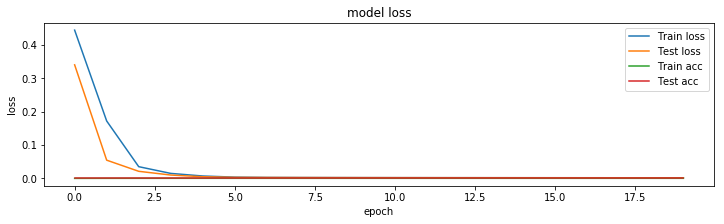

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss', 'Train acc', 'Test acc'], loc='upper right');
plt.show()

In [113]:
predicted = autoencoder.predict(test_x, batch_size=b_size)

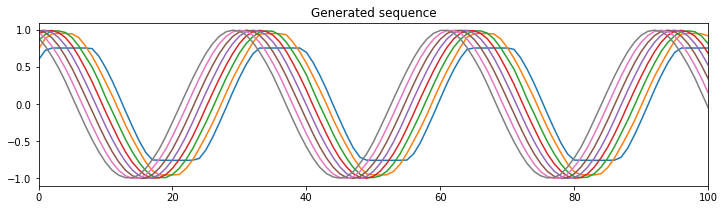

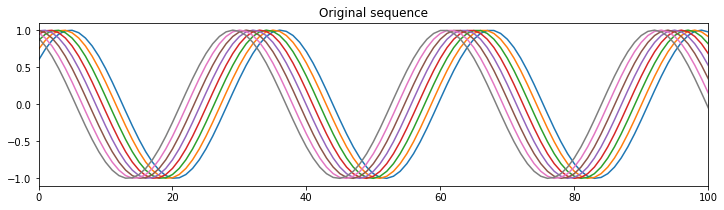

In [114]:
pred = predicted.reshape(predicted.shape[0],predicted.shape[1]*predicted.shape[2])
test = test_x.reshape(test_x.shape[0],test_x.shape[1]*test_x.shape[2])

plt.title('Generated sequence')
plt.plot(pred)
plt.xlim(0,100)
plt.show()

plt.title('Original sequence')
plt.plot(test)
plt.xlim(0,100)
plt.show()